# Diabetes prediction

This app predicts if a person has diabetes or not based on some diagnostic measurements. The data used for training the model is obtained from the [Diabetes Dataset](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) on Kaggle.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)
sns.set_theme(style="whitegrid")

## Import dataset

In [2]:
diabetes_data = pd.read_csv('diabetes.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The Outcome variable is our target variable. It is a binary variable that indicates if the patient has tested positive for diabetes or not. 1 means the patient test is positive and 0 means the patient test is negative.     

## EDA

In [3]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


There are 768 rows and 9 columns in the dataset, with no missing values.

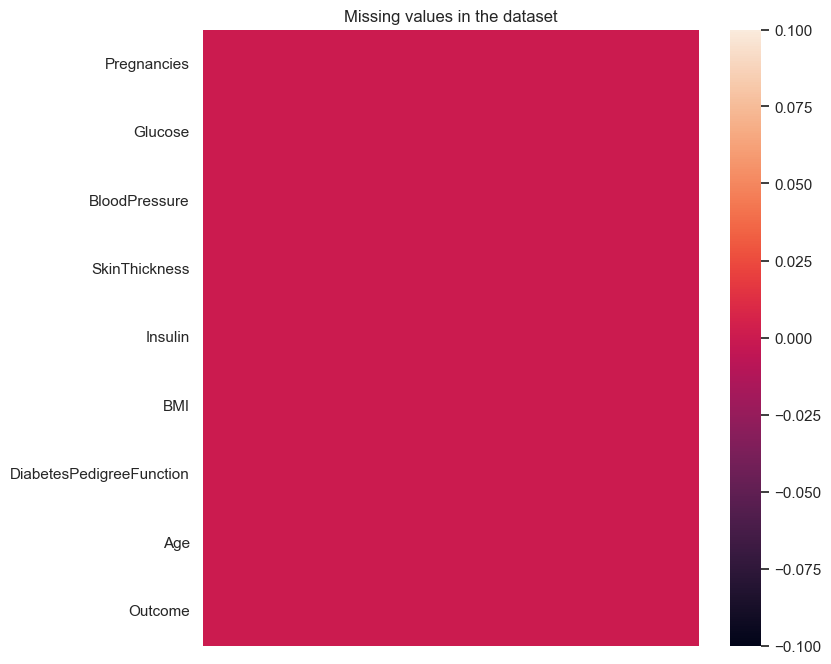

In [4]:
ax, fig = plt.subplots(figsize=(8, 8))    
img = sns.heatmap(diabetes_data.transpose().isnull())
img.set_title('Missing values in the dataset')
img.set_xticks([])
img.tick_params(axis='x', which='major', labelsize=6)   

In [5]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


The Pregnancies variable has a maximum value of 17, which is quite high, so we will check for outliers.

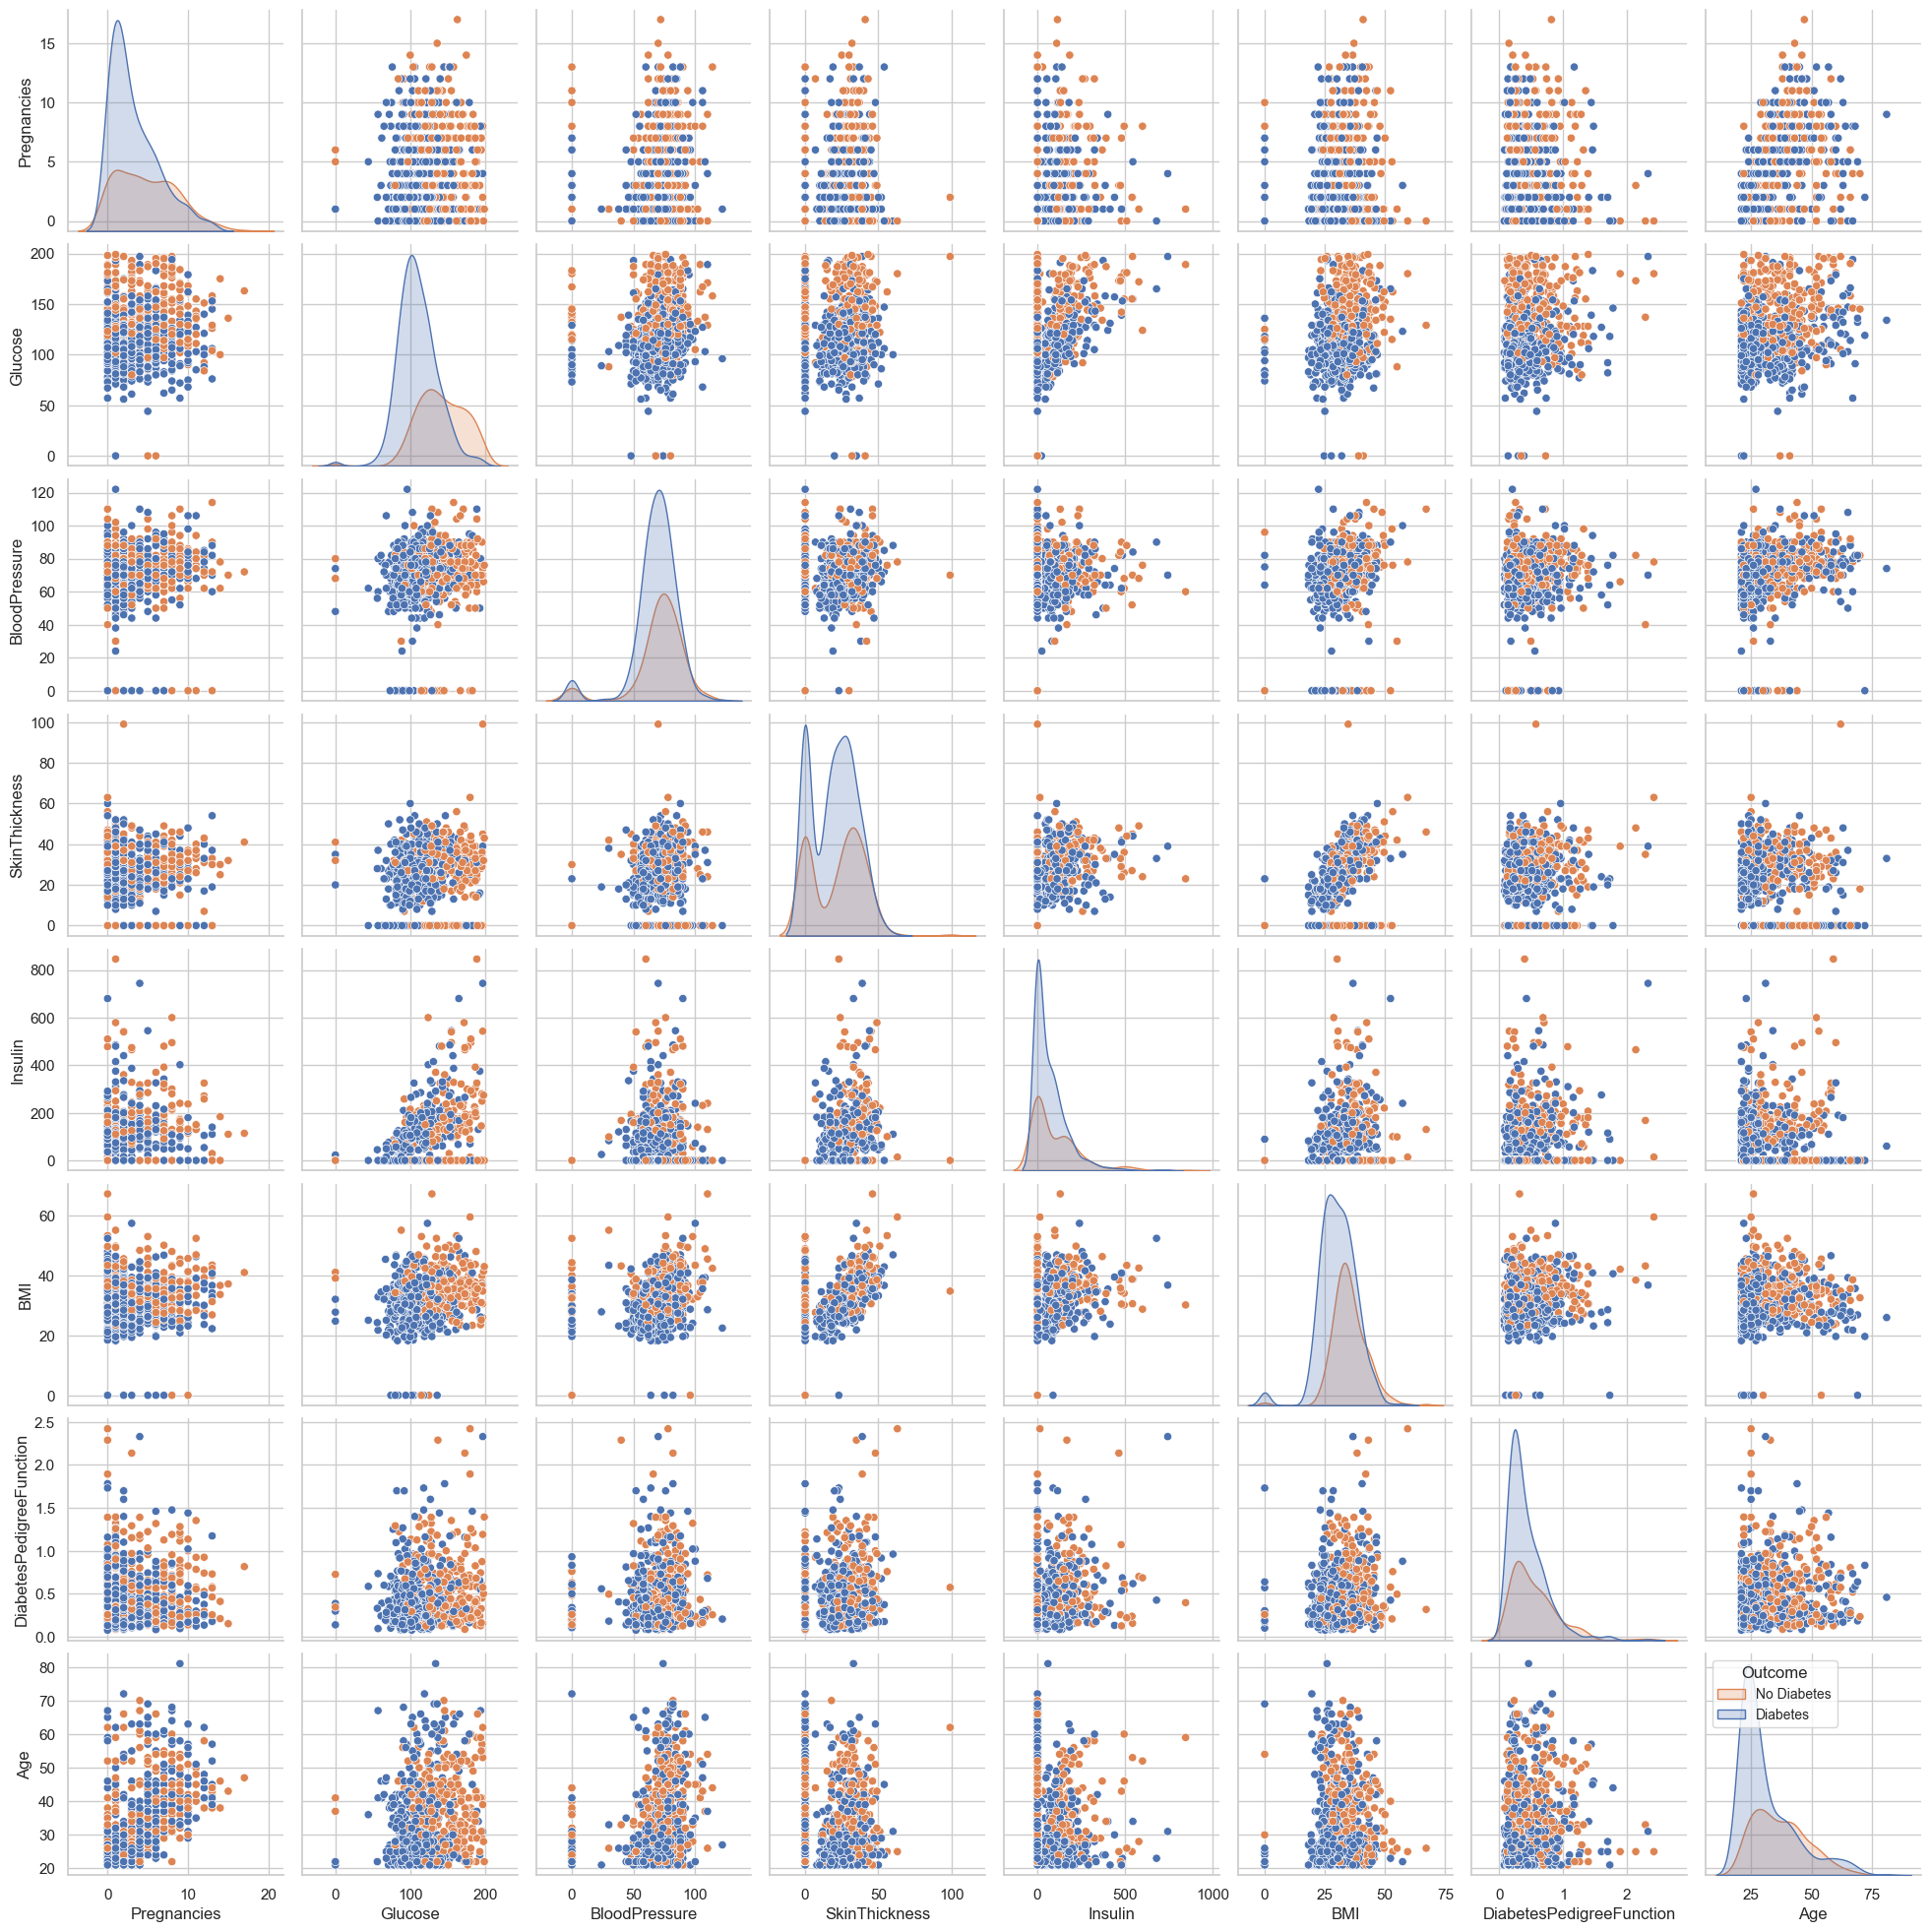

In [6]:
fig = sns.pairplot(diabetes_data, hue='Outcome')
fig._legend.remove()
#plt.legend([],[], frameon=False)
plt.legend(title='Outcome', loc=2, labels=['No Diabetes', 'Diabetes'], prop={'size': 10})       



All the variables present a big difference in distribution between the outcome classes, which is a good sign for the model. 
Let's check for outliers in all the variables.

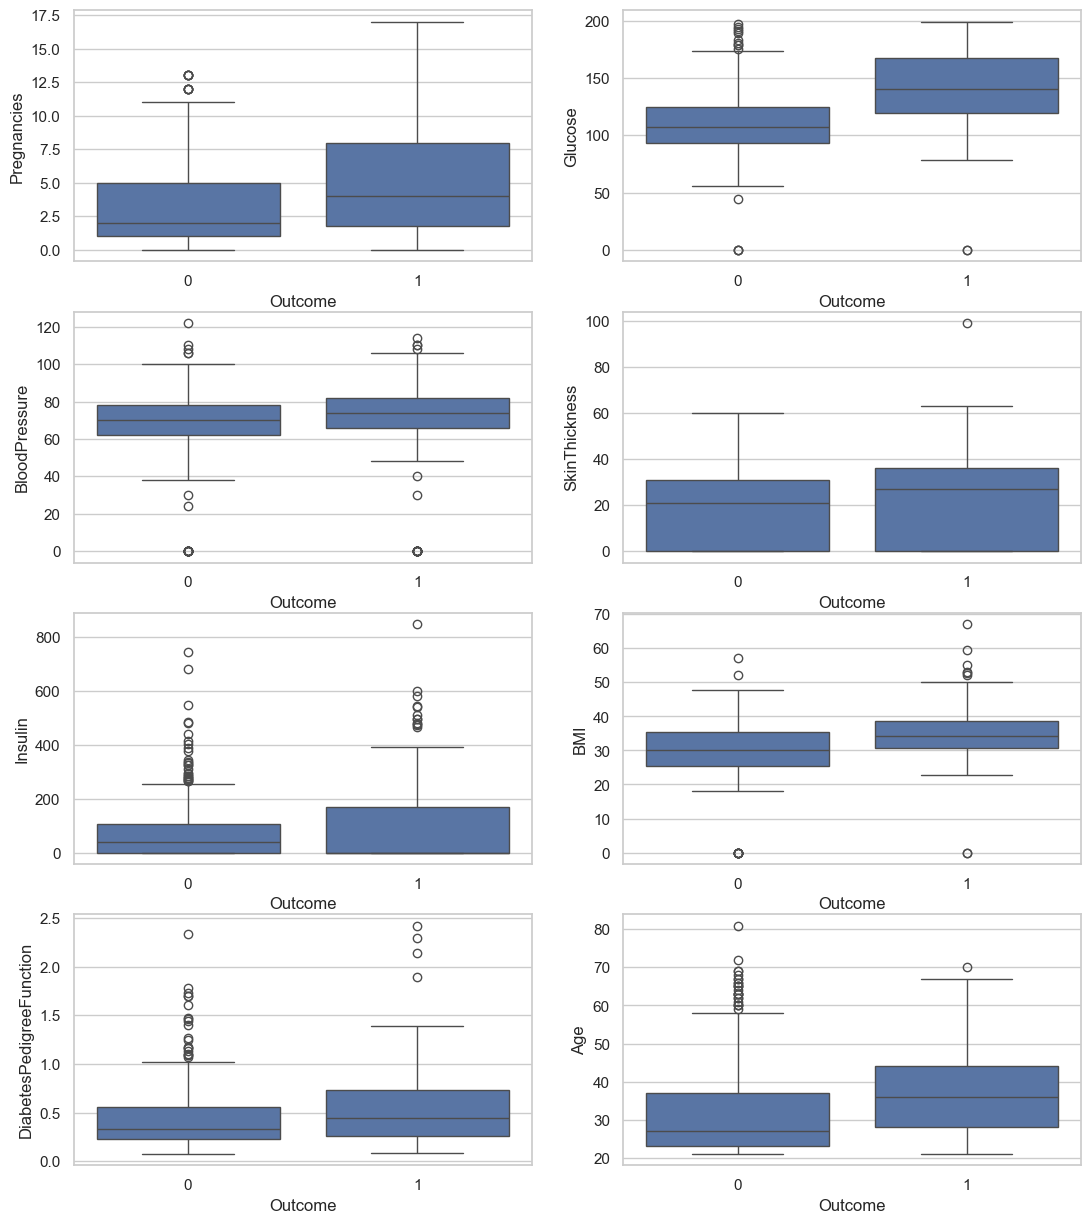

In [7]:
fig, ax = plt.subplots(figsize=(13, 15), ncols=2, nrows=4)
for axis, variable in zip(ax.flat, diabetes_data.columns):
    sns.boxplot(x='Outcome', y=variable, data=diabetes_data, ax=axis)

Variables like DiabetesPedigreeFunction, Age, Insulin and Glucose have many outliers, so we are going to remove them using the IQR method.

In [8]:
def outlier_removal(column, data, fence_coef=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outlier detection
    lower_bound = Q1 - fence_coef * IQR
    upper_bound = Q3 + fence_coef * IQR

    # Remove outliers from the dataset
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]
diabetes_data.drop(outlier_removal('DiabetesPedigreeFunction', diabetes_data).index, inplace=True)
diabetes_data.drop(outlier_removal('Age', diabetes_data).index, inplace=True)
diabetes_data.drop(outlier_removal('Insulin', diabetes_data).index, inplace=True)
diabetes_data.drop(outlier_removal('Glucose', diabetes_data).index, inplace=True)

We end up with 684 rows of data.

In [9]:
diabetes_data.shape

(684, 9)

We dropped some outliers from the Pregnancies variable. Let's check the correlation between the variables.

<Axes: >

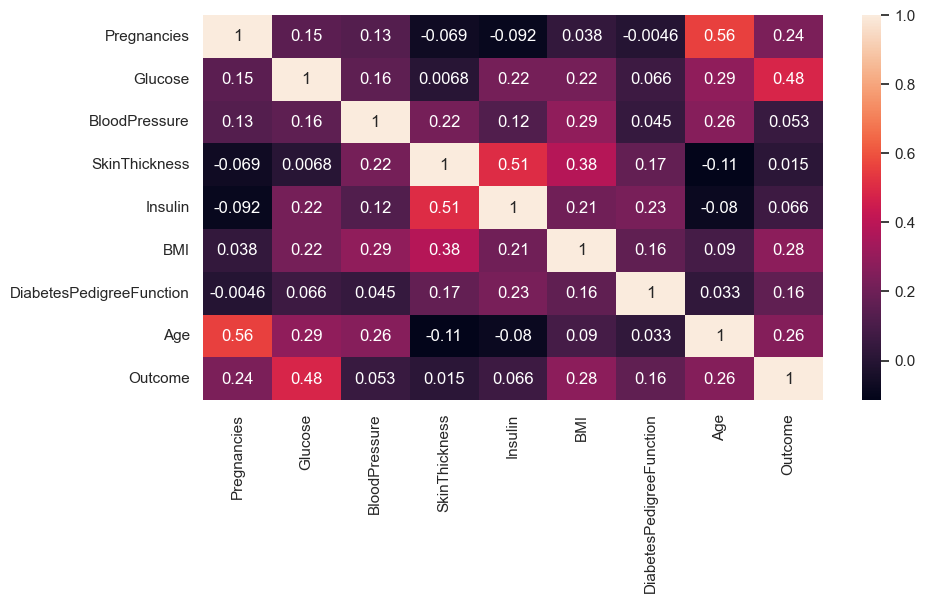

In [10]:
plt.figure(figsize=(10, 5))
sns.heatmap(diabetes_data.corr(), annot=True)

There is no significant correlation between the variables, so we will keep all of them for the model.

Now we are going to see the balance of the target variable.

Text(0, 0.5, '')

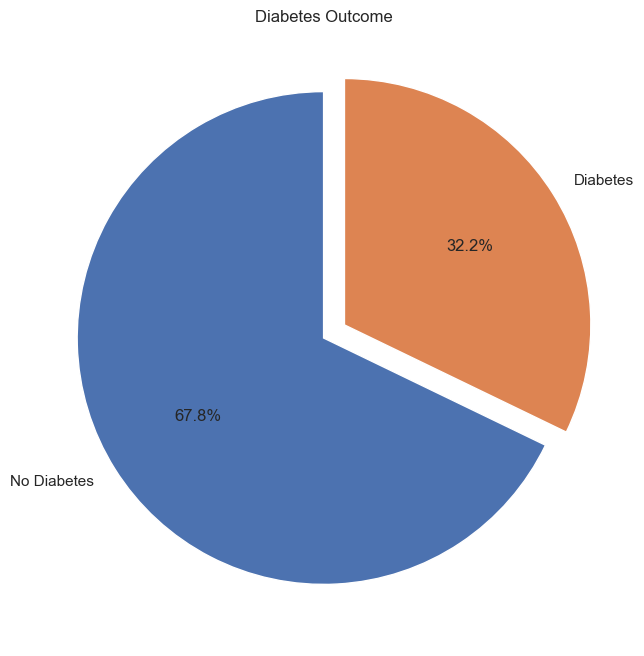

In [11]:
#create a donut plot for the target variable
plt.figure(figsize=(8, 8))
explode = (0, 0.1)
diabetes_data['Outcome'].value_counts().plot(kind='pie', autopct='%1.1f%%', explode=explode, startangle=90,
                                             labels=['No Diabetes', 'Diabetes'])
plt.title('Diabetes Outcome')
plt.ylabel('')

There is an imbalance in the target variable, so we will have to take this into account when training the model.

## Train Test Split

We are going to split the data using StratifiedKFold, which is a variation of KFold. The folds are made by preserving the percentage of samples for each class. In this case, we will have 5 folds.

We are going to score the models using recall but other metrics will be presented (AUC, accuracy, precision). This is due to the fact that we want to maximize the number of true positives (patients that have diabetes and are predicted to have diabetes). We want to minimize the number of false negatives (patients that have diabetes but are predicted to not have diabetes). In this case, it is better to have false positives (patients that do not have diabetes but are predicted to have diabetes) than false negatives.

In [12]:
#create a grid search that test different splits of the data, and different models 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold


#split the data into train and test sets
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
scoring = {'Accuracy': 'accuracy','AUC': 'roc_auc', 'Precision': 'precision', 'Recall':'recall'}

#create a pipeline for each model
pipe_log = Pipeline([('scaler', StandardScaler()), ('log', LogisticRegression())])
pipe_rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])
pipe_svc = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

#set up the parameter grids for each model
param_grid_log = {'log__C': [0.01, 0.1, 1, 10]}
param_grid_rf = {'rf__n_estimators': [100, 200, 300, 400], 'rf__max_depth': [2, 3, 4, 5]}
param_grid_svc = {'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'svc__C': [0.1, 1, 10]}
param_grid_knn = {'knn__n_neighbors': [3, 4, 5, 6, 7]}
param_grids = [param_grid_log, param_grid_rf, param_grid_svc, param_grid_knn]

#set up the grid search for each model
grid_log = GridSearchCV(pipe_log, param_grid_log, cv=cv, n_jobs=-1, scoring=scoring, refit='Recall')
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=cv, n_jobs=-1, scoring=scoring, refit='Recall')
grid_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=cv, n_jobs=-1, scoring=scoring, refit='Recall')
grid_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=cv, n_jobs=-1, scoring=scoring, refit='Recall')
grids = [grid_log, grid_rf, grid_svc, grid_knn]

#fit each grid search to the training data
for grid in grids:
    grid.fit(X_train, y_train)
    print(f'Model: {grid.estimator.steps[1][0]} \tBest parameters: {grid.best_params_}')
    for score in scoring.keys():
        print(f'{score}: {grid.cv_results_[f'mean_test_{score}'][grid.best_index_]:.2f}',end='\t')
    print('\n')
    print('-'*50)


Model: log 	Best parameters: {'log__C': 1}
Accuracy: 0.79	AUC: 0.84	Precision: 0.73	Recall: 0.55	

--------------------------------------------------
Model: rf 	Best parameters: {'rf__max_depth': 5, 'rf__n_estimators': 200}
Accuracy: 0.78	AUC: 0.83	Precision: 0.72	Recall: 0.53	

--------------------------------------------------
Model: svc 	Best parameters: {'svc__C': 10, 'svc__kernel': 'linear'}
Accuracy: 0.80	AUC: 0.84	Precision: 0.75	Recall: 0.56	

--------------------------------------------------
Model: knn 	Best parameters: {'knn__n_neighbors': 3}
Accuracy: 0.71	AUC: 0.73	Precision: 0.55	Recall: 0.49	

--------------------------------------------------


We are going to use the random forest classifier for explainability purposes. 

## Hyperparameter Tuning and Other Techniques

### SMOTE

SMOTE is a technique that creates more samples of the minority class, so that the classes are balanced. The way it works is by creating synthetic samples from the minor class instead of creating copies. It randomly picks a point from the minor class and computes the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

In [13]:
from imblearn.over_sampling import SMOTE

print('Before SMOTE:')
print(y_train.value_counts())
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print('After SMOTE:')
print(y_train_smote.value_counts())

Before SMOTE:
Outcome
0    371
1    176
Name: count, dtype: int64
After SMOTE:
Outcome
0    371
1    371
Name: count, dtype: int64


So the proportion of the minority class is increased, and the classes are balanced.
Let's see how the data looks like after applying SMOTE.(for visualization purposes, we are going to use TSNE to reduce the dimensionality of the data)

Text(0.5, 1.0, 'SMOTE Data')

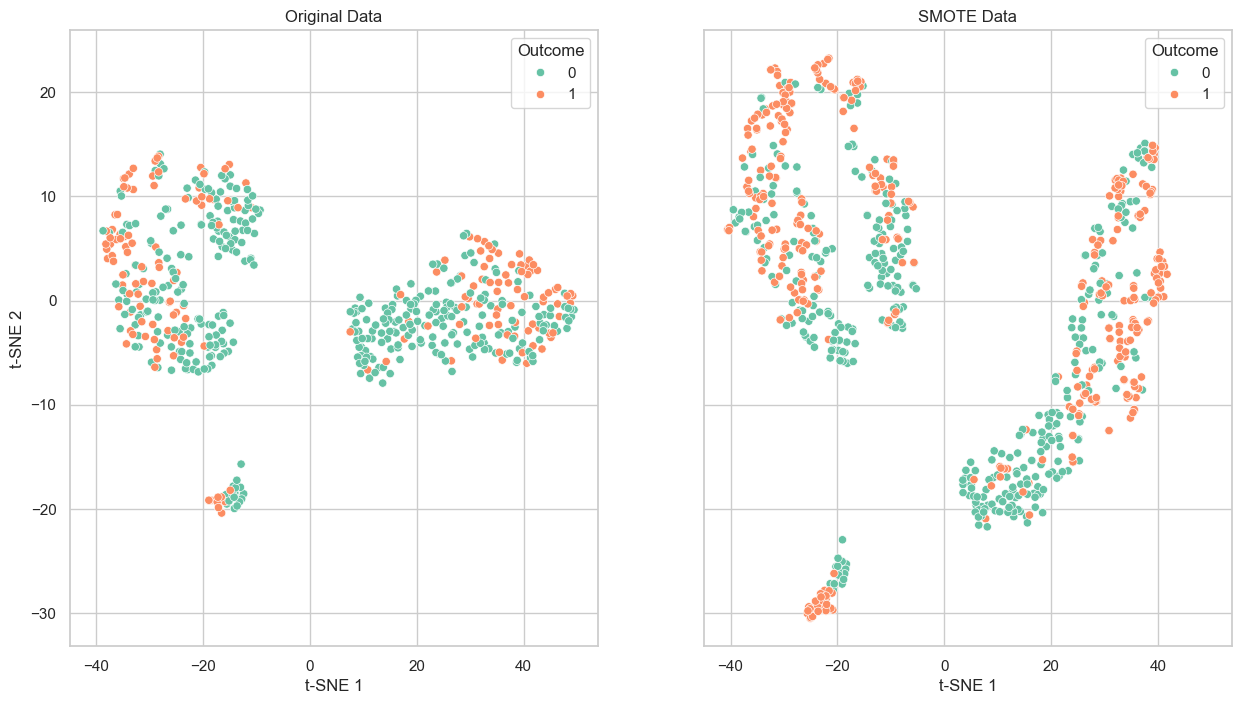

In [14]:
from sklearn.manifold import TSNE

#set up the model
tsne = TSNE(n_components=2, random_state=42)

X_smote_tsne = tsne.fit_transform(X_train_smote)
X_tsne = tsne.fit_transform(X_train)

#plot the data
fig,  ax = plt.subplots(figsize=(15, 8), ncols=2, sharex=True, sharey=True)
for axis, x_, y_ in zip(ax.flat, [X_tsne, X_smote_tsne], [y_train, y_train_smote]):
    sns.scatterplot(x=x_[:,0], y=x_[:,1], hue=y_, ax=axis, palette='Set2')
    # axis.get_legend().remove()
    axis.set_xlabel('t-SNE 1')
    axis.set_ylabel('t-SNE 2')
    # axis.legend(title='Outcome', loc=2, labels=['No Diabetes', 'Diabetes'], prop={'size': 10})
ax[0].set_title('Original Data')
ax[1].set_title('SMOTE Data')

    

As we can see, there are more samples of the minority class now. Let's see how this affects the model.

In [18]:
from imblearn.pipeline import Pipeline as imbPipeline

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pipeline = imbPipeline([('smote', SMOTE(random_state=42)), ('model', RandomForestClassifier(random_state=42))])
param_grid = {'model__n_estimators': [100, 200, 300, 400], 'model__max_depth': [2, 3, 4, 5], 
              'model__criterion': ['gini', 'entropy', 'log_loss'],'model__class_weight': ['balanced', 'balanced_subsample'],
              'model__min_samples_leaf':[1,2,3], 'smote__k_neighbors': [3, 4, 5, 6, 7]}
grid = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1, scoring=scoring, refit='AUC')
grid.fit(X_train, y_train)
for score in scoring.keys():
    print(f'{score}: {grid.cv_results_[f'mean_test_{score}'][grid.best_index_]:.2f}',end='\t')
print()
print(f'grid.best_params_: {grid.best_params_}')

Accuracy: 0.74	AUC: 0.83	Precision: 0.58	Recall: 0.77	
grid.best_params_: {'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__n_estimators': 400, 'smote__k_neighbors': 7}


Let's train the model with the best parameters on the entire training set and evaluate it on the test set.

In [58]:
smote = grid.best_estimator_.named_steps['smote']
model = grid.best_estimator_.named_steps['model']
pipeline = imbPipeline([('smote', smote), ('model', model)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(k_neighbors=7, random_state=42)),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=3,
                                        min_samples_leaf=4, n_estimators=400,
                                        random_state=42))])

Using SMOTE, we get a better recall score, but a lower accuracy score. This is due to the fact that we have more false positives now, but less false negatives. Let's see change the threshold to see if we can get a better recall score without affecting the accuracy score too much.

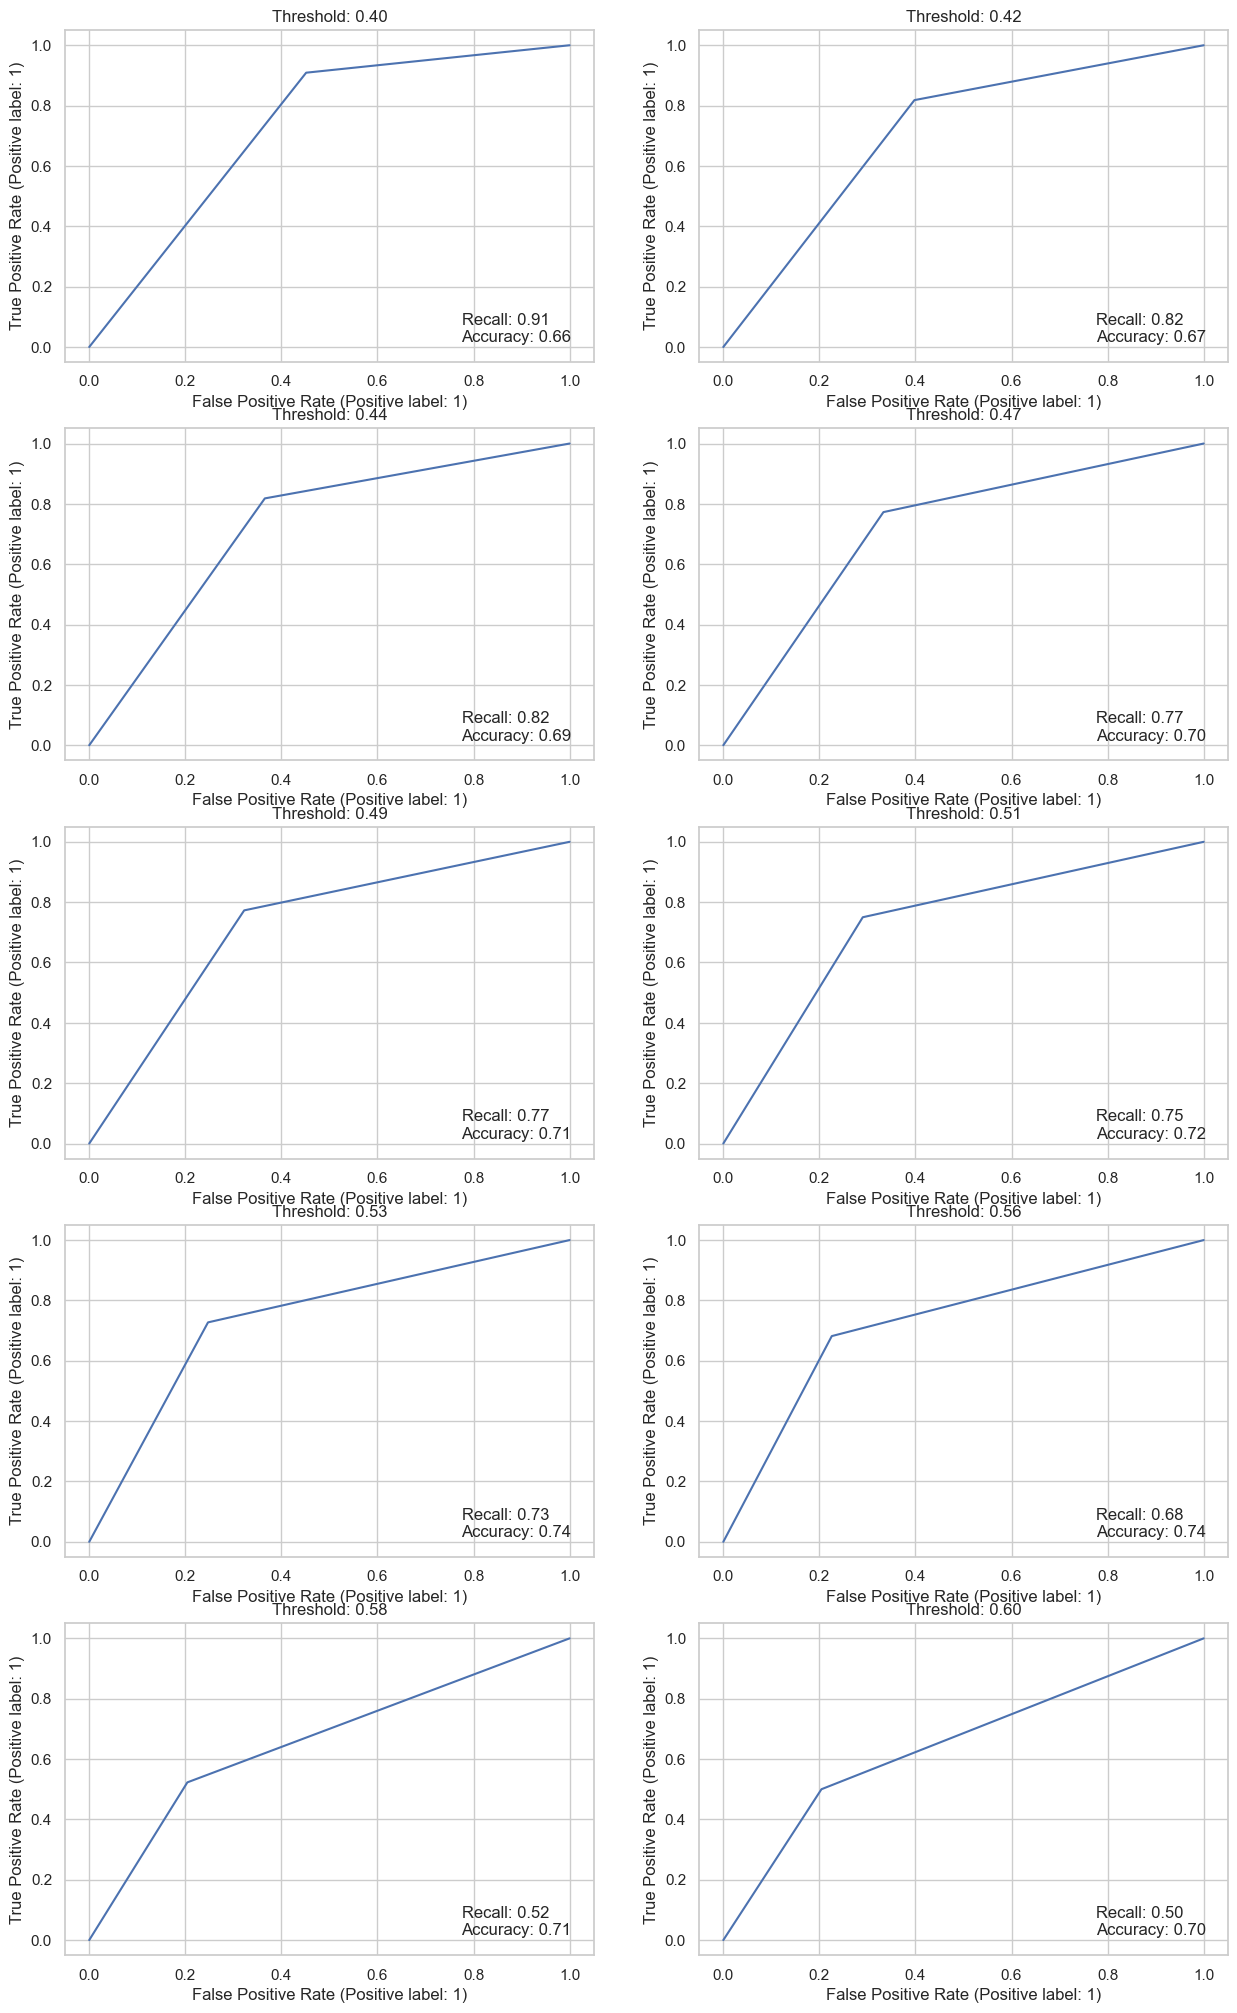

In [59]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import recall_score, accuracy_score
thresholds = np.linspace(0.4, 0.6, 10)
fig, ax = plt.subplots(figsize=(15, 25), ncols=2, nrows=5)
for axis, threshold in zip(ax.flat, thresholds):
    y_pred = pipeline.predict_proba(X_test)[:,1] > threshold
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    RocCurveDisplay.from_predictions(y_test, y_pred, ax=axis)
    axis.set_title(f'Threshold: {threshold:.2f}')
    axis.get_legend().remove()
    axis.text(0.75, 0.1, f'Recall: {recall:.2f}\nAccuracy: {accuracy:.2f}', horizontalalignment='left', verticalalignment='center', transform=axis.transAxes, fontsize=12)

    

We can improve the recall score by changing the threshold, however the accuracy score is affected too much. So we are going to keep the default threshold.
Our final score on test set is

In [67]:
accuracy = pipeline.score(X_test, y_test)
recall = recall_score(y_test, pipeline.predict(X_test))
print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy: 0.72
Recall: 0.75


<Figure size 800x800 with 0 Axes>

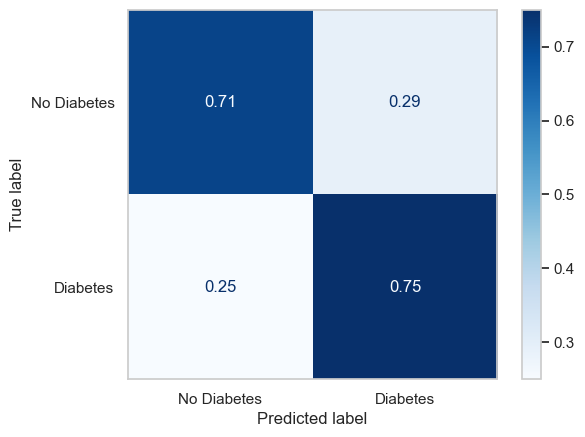

In [66]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize=(8, 8))

ConfusionMatrixDisplay.from_predictions(y_test, pipeline.predict(X_test), display_labels=['No Diabetes', 'Diabetes'],
                                        normalize='true', cmap='Blues')
plt.grid(False)

 Let's see the feature importance obtained from the model.

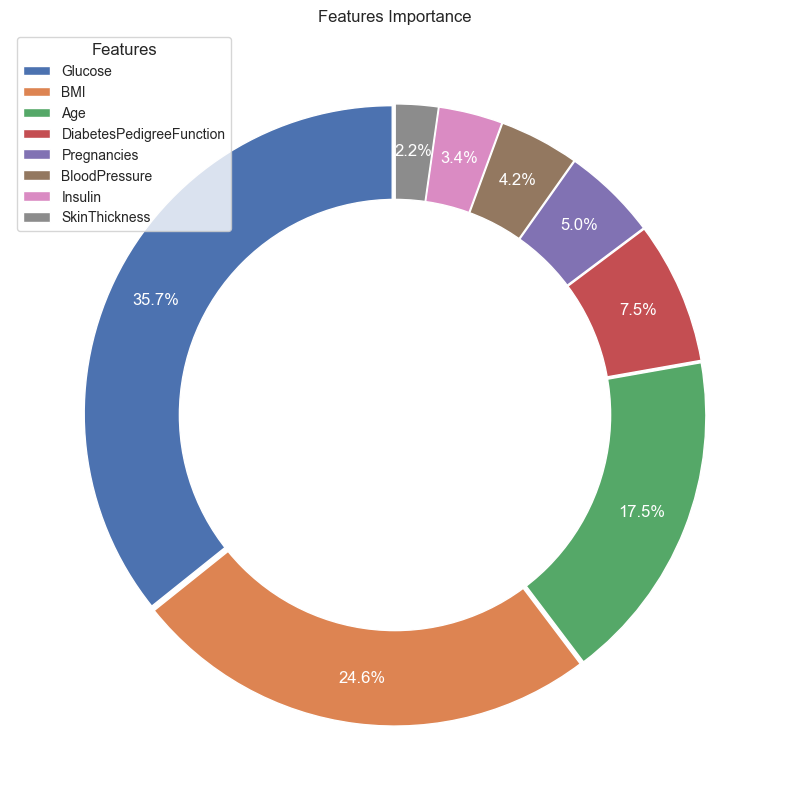

In [52]:
features_importance = pd.DataFrame({'Features': X_train.columns, 'Importance': pipeline.named_steps['model'].feature_importances_})
features_importance.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(15, 10))
explode = ( 0.01, 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01)
pie = plt.pie(features_importance['Importance'], labels=features_importance['Features'], 
              autopct='%1.1f%%', explode=explode, startangle=90, pctdistance=0.85, labeldistance=1.1, textprops={'color':"w"})
plt.title('Features Importance')
plt.ylabel('')
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# remove labels from the pie 
for text in pie[1]:
    text.set_visible(False)
# create a legend
plt.legend(title='Features', loc=2, labels=features_importance['Features'], prop={'size': 10})
# move the percentage inside the pie


So the most important features are Glucose, BMI and Age. Let's see if we can improve the model by removing SkinThickness from the dataset.

In [73]:
X_train_ = X_train.drop(['SkinThickness'], axis=1)
pipeline_new = pipeline.fit(X_train_, y_train)
y_pred = pipeline_new.predict(X_test.drop(['SkinThickness'], axis=1))
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')

Accuracy: 0.73
Recall: 0.77


Removing SkinThickness from the dataset is an improvement, so we are going to keep it that way. The 

<Figure size 800x800 with 0 Axes>

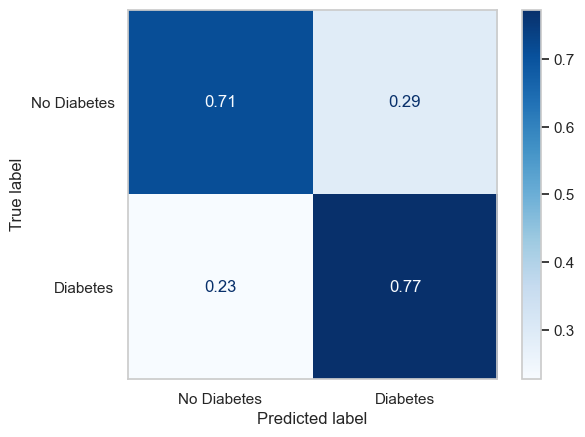

In [77]:
plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['No Diabetes', 'Diabetes'],
                                        normalize='true', cmap='Blues')
plt.grid(False)

In [79]:
import joblib
joblib.dump(pipeline_new, 'diabetes_model.pkl')

['diabetes_model.pkl']